# Lab 7 and 8

## Jennifer Vo, lab partners with William Olsen

### Lab 7: Event Selection Optimization

## Introduction and Selection

In this lab, my partner and I will be optimizing the event selections in our LHC training samples. I will be working with the low PT training sample datasets, which come in two files: the QCD background dataset and the Higgs Boson signal dataset. In this dataset the PT (transverse momentum) lies between 250 and 500. There are 100k total events (jets; simulated) in each data set. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets. (theory)

Since we will be altering the total number of data samples we are working with from 100k samples to some smaller value, the expected yields of both the signal and the background will decrease. In order to calculate this sensitivity, we will need to normalize each sample.

The ratio $R = \frac{N_{new, sim}}{N_{old,sim}}$ represents the fraction of simulated data points that we would keep after a cut, where $N_{new, sim}$ is the number of simulated data points after the cut, and $N_{old, sim}$ is the number of simulated data points before the cut.

This ratio can then be used to calculate the expected yield of a dataset after a cut:
$$N_{new, exp} = R * N_{old, exp}$$

where $N_{old, exp}$ is the expected yield before a cut.

If I substitute the ratio R into my formula for $N_{new, exp}$, I get:
$$N_{new, exp} = \frac{N_{new, sim}}{N_{old,sim}} * N_{old, exp}$$

Our expected yields are $N_{old,exp,higgs}$ = 100 Higgs signal jets and $N_{old,exp,qcd}$ = 20,000 QCD background jets, with $N_{old,sim}$ = 100,000 events for both. The fraction 100/100,000 equals 0.001 and the fraction 20,000/100,000 equals 0.2. Thus after any cuts I make on the data set I will be able to calculate the expected yields with the following formulas:

$$N_{new, exp, qcd} = N_{new, sim, qcd} * 0.2 $$
$$N_{new, exp, higgs} = N_{new, sim, higgs} * 0.001 $$

In the previous labs (Lab 5), I identified the different variables which held discrimination power between the Higgs Boson signal data and the QCD background data. In this lab, I will be plotting more histograms to work through the optimization process comprehensively. 

First let's import the required libraries for this lab and load the files' datasets into arrays that I can work with.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

# open the qcd background data file, and use pickle loading
infile = open("qcd250-500.pkl",'rb')
qcd_dict = pickle.load(infile)

# open the higgs signal data file, and use pickle loading
infile = open("higgs250-500.pkl",'rb')
higgs_dict = pickle.load(infile)

## Part 1
First, I will be working with the variable "mass". This variable represents the sum of the masses of the jet's particles, produced in the collision. I would first like to create a stacked histogram plot for mass. In this case, I will create a stacked histogram by accessing the data from each file, creating a two-dimensional array with 100,000 rows and 2 columns, which contains the mass measurement from all jet events in both the background and the Higgs signal data. Once I plot this on the stacked histogram I will distinguish them by color.

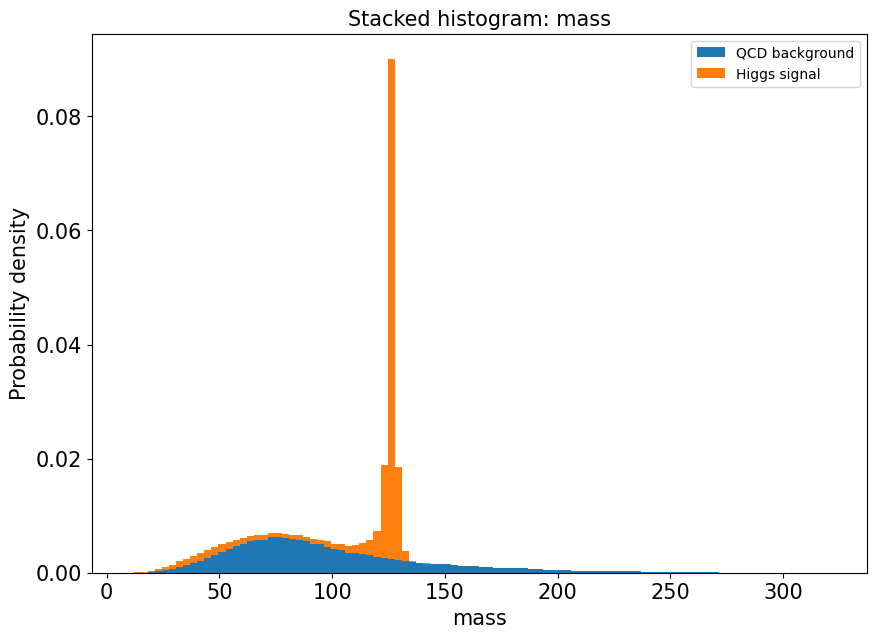

In [2]:
def plot_st_hist(var):
    w, h = 100000, 2
    combined = [[0 for x in range(w)] for y in range(h)]
    for i in range (0, 100000):
        combined[0][i] = qcd_dict[f'{var}'][i]
        combined[1][i] = higgs_dict[f'{var}'][i]

    plt.hist(combined, 100, density=True, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 15)
    plt.ylabel('Probability density', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

#this sets the size of the plots to something useful
plt.rcParams["figure.figsize"] = (10,7)
plot_st_hist('mass')

As we can see, the stacked histogram plot shows that the two datasets have a similar range of values, from 0 to around 270. However, it is clear that the Higgs signal has a much greater association with mass values around approximately 125 GeV.

Next I would like to evaluate the expected significance for this initial case without any event selection. I will assume that the QCD background particle events are Poisson-distributed because the event counts are discrete with very small probabilities of occurring. The expected yield for the Higgs Boson signal data is 100 jets and the expected yield for QCD background data is 20,000 jets. Thus a measurement that is most likely to come from a true Higgs boson signal (in this dataset) would be 20,100 jets = 20,000 + 100.

Therefore, to calculate the significance I will model for the QCD background a Poisson-distribution with the average parameter $\lambda$ = 20,000 jets, and a measurement of the Higgs signal being 20,100 jets. The question is thus: __"What would be the statistical significance for the background, a Poisson distribution with $\lambda$ = 20,000 to produce a signal of 20,100 or greater?"__

Intuitively, the significance level associated with this probability would be very low, too low to be considered as a physics discovery (which requires 5 sigma). Let us calculate this:

In [3]:
def calc_sigma_poisson(lam, signal):
    prob = stats.poisson.sf(signal, lam)
    sigma = stats.norm.isf(prob)
    
    return sigma
    
def calc_signal_poisson(lam, sigma):
    prob = stats.norm.sf(sigma)
    signal = stats.poisson.isf(prob, lam)
    
    return signal
    
sigma_base = calc_sigma_poisson(20000,20100)
print(f'The significance of the background QCD particles producing a measurement of 20,100 jets is {sigma_base:.4f} sigma.')

The significance of the background QCD particles producing a measurement of 20,100 jets is 0.7112 sigma.


As predicted, the significance of this is very low, not even 1 sigma.

Let us compare this significance to the approximation $\frac{N_{old, exp, Higgs}}{\sqrt{N_{old, exp, QCD}}}$, where $N_{old, exp, Higgs}$ is the initial expected Higgs signal yield, and $N_{old, exp, QCD}$ is the initial expected QCD background yield. This approximation is calculated to be $100/\sqrt{20000} = 100/141.421 \text{which approximately = } 0.7071$. This is very close to what we obtained, 0.7112. They are approximately equal but not quite. I will now explain why this is:

First, one important property of the Poisson distribution is that for large values of $\lambda$, the Poisson distribution can be approximated by a Gaussian distribution. This means we can use Gaussian statistics as an approximation for the distribution.

The other important property of the Poisson distribution is that both the expected value and the variance are equal to the parameter $\lambda$. Thus, for our QCD background distribution, the parameter $\lambda = 20,000$ implies a variance of 20,000 and a standard deviation of $\sqrt{20000} = 141.421$, this is what is the denominator of the approximation $\frac{N_{old, exp, Higgs}}{\sqrt{N_{old, exp, QCD}}}$.

Putting these two facts together, we see that a deviation of 100 from the mean of the background distribution (20,000) would be $\frac{100}{141.421} \sigma$ or approximately $0.7071 \sigma$ away from the mean.

## Part 2
Now that we have established the baseline significance I would like to optimize the expected significance by identifying first the best cut of the mass data. We saw that the Higgs signal is strongly associated with a mass around 125 GeV, but ranges between around 25 and 140 GeV. Therefore I will explore cuts around this value.

I will make cuts incrementally and compute the expected significance for each one, then determine which cut results in the highest significance. To start, I will make a first cut to keep data in the range of 100 and 150 GeV, then narrow it down to smaller windows in increments of 5 GeV from both sides symmetrically to approach 125 GeV.

In [4]:
def slice_data(qcd, higgs, var, low, high, toReturn):
    # slice qcd
    ind_qcd_below = qcd[qcd[f'{var}'] < low].index
    ind_qcd_above = qcd[qcd[f'{var}'] > high].index
    new_qcd = qcd.drop(ind_qcd_below)
    new_qcd = new_qcd.drop(ind_qcd_above)
    
    # slice higgs
    ind_higgs_below = higgs[higgs[f'{var}'] < low].index
    ind_higgs_above = higgs[higgs[f'{var}'] > high].index
    new_higgs = higgs.drop(ind_higgs_below)
    new_higgs = new_higgs.drop(ind_higgs_above)
    
    # calc new expected yields of qcd and higgs using the ratio a = 0.2 and b = 0.001 (calculated in introduction)
    a = 0.2
    b = 0.001
    y_qcd = int(a * len(new_qcd))
    perc_qcd = len(new_qcd) / 100000
    y_higgs = int(b * len(new_higgs))
    perc_higgs = len(new_higgs) / 100000
    
    #finally, calc new significance
    sigma = calc_sigma_poisson(y_qcd, y_qcd + y_higgs)
    
    if toReturn:
        return new_qcd, new_higgs, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs
    else:
        return (f'Slicing data to keep range {low} to {high} GeV... The statistical significance of a yield of {y_higgs} jets is {sigma:.4f} sigma.')

print(slice_data(qcd_dict, higgs_dict, 'mass', 0, 300, False)) # check -> process is correct
print(slice_data(qcd_dict, higgs_dict, 'mass', 100, 150, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 105, 145, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 110, 140, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 115, 135, False))
print(slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, False))

Slicing data to keep range 0 to 300 GeV... The statistical significance of a yield of 100 jets is 0.7113 sigma.
Slicing data to keep range 100 to 150 GeV... The statistical significance of a yield of 84 jets is 1.1731 sigma.
Slicing data to keep range 105 to 145 GeV... The statistical significance of a yield of 84 jets is 1.3247 sigma.
Slicing data to keep range 110 to 140 GeV... The statistical significance of a yield of 82 jets is 1.4987 sigma.
Slicing data to keep range 115 to 135 GeV... The statistical significance of a yield of 81 jets is 1.8211 sigma.
Slicing data to keep range 120 to 130 GeV... The statistical significance of a yield of 75 jets is 2.3870 sigma.


As we can see the best cut corresponds to that between a low of 120 GeV and a high of 130 GeV, where we cut down from 100 jets to 75. This corresponds with an expected significance of 2.3870$\sigma$.

In [5]:
perc_qcd_mass_cut = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)[5]
perc_higgs_mass_cut = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)[6]
print(f'The percentage of qcd background data that the mass cut kept is {perc_qcd_mass_cut*100:.2f}% of the original dataset.')
print(f'The percentage of higgs data that the mass cut kept is {perc_higgs_mass_cut*100:.2f}% of the original dataset.')

The percentage of qcd background data that the mass cut kept is 4.90% of the original dataset.
The percentage of higgs data that the mass cut kept is 75.85% of the original dataset.


## Part 3
Now that we have the results from slicing the datasets based on the mass feature, I would like to plot stacked histograms for each of the features. For each feature, Set A will consist of stacked histograms without any event selection, and Set B will consist of stacked histograms with my mass cut, keeping only that data with the mass feature within the range of 120-130 GeV.

After plotting, I will make observations.

In [25]:
# def function to plot stacked histograms before (set A) and after (set B) optimal mass cut
def plot_comparison(qcd, higgs, qcd_sliced, higgs_sliced, var, var_slice):
    combined = [qcd[f'{var}'], higgs[f'{var}']]

    plt.subplot(2,1,1)
    plt.hist(combined, 100, density=False, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Event counts', fontsize = 15)
    plt.title(f'Stacked histogram: {var}', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()
    
    combined_sliced = [qcd_sliced[f'{var}'], higgs_sliced[f'{var}']]
    
    plt.subplot(2,1,2)
    plt.hist(combined_sliced, 100, density=False, histtype='bar', stacked=True, label=['QCD background', 'Higgs signal'])
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Event counts', fontsize = 15)
    plt.title(f'Stacked histogram: {var} with {var_slice} cut', fontsize = 13)

    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

output = slice_data(qcd_dict, higgs_dict, 'mass', 120, 130, True)
plt.rcParams["figure.figsize"] = (10,12)

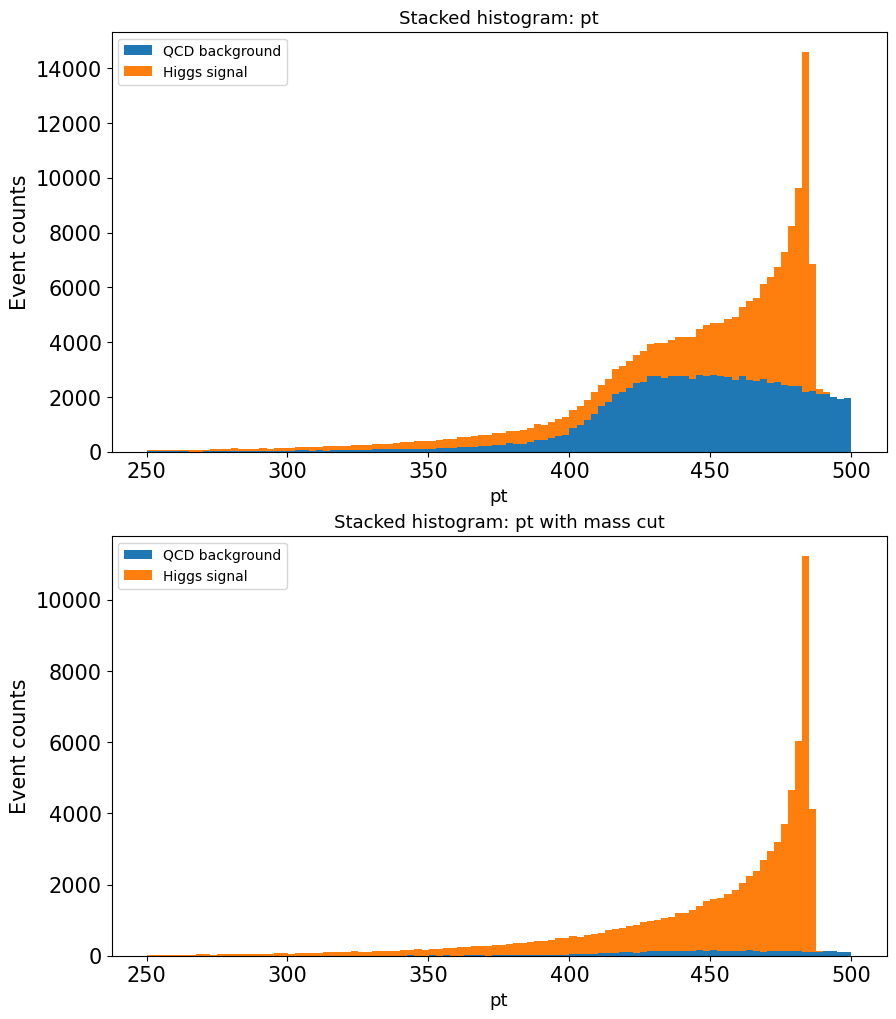

In [26]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'pt', 'mass')

With pt, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range. This suggests there is low discriminatory power for slicing based on pt.

The pt Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on pt as the data range significantly overlaps.

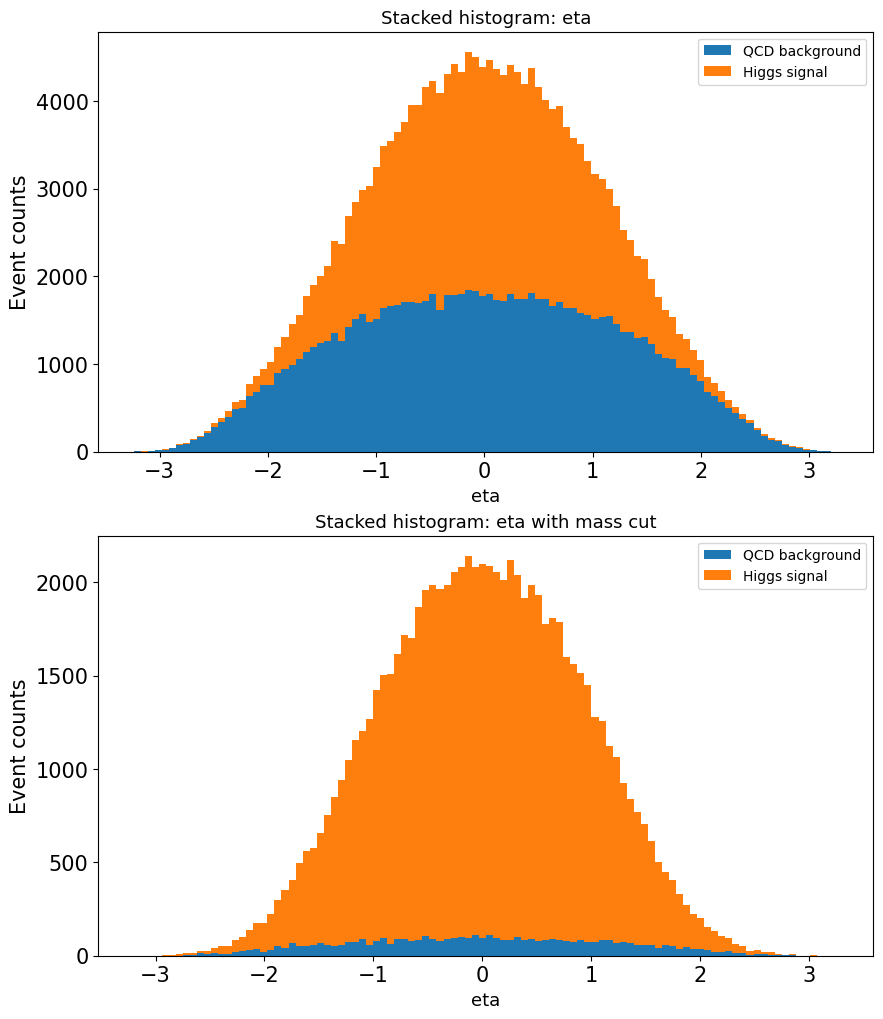

In [27]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'eta', 'mass')

With eta, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range. This suggests there is low discriminatory power for slicing based on eta.

The eta Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on eta as the data range entirely overlaps.

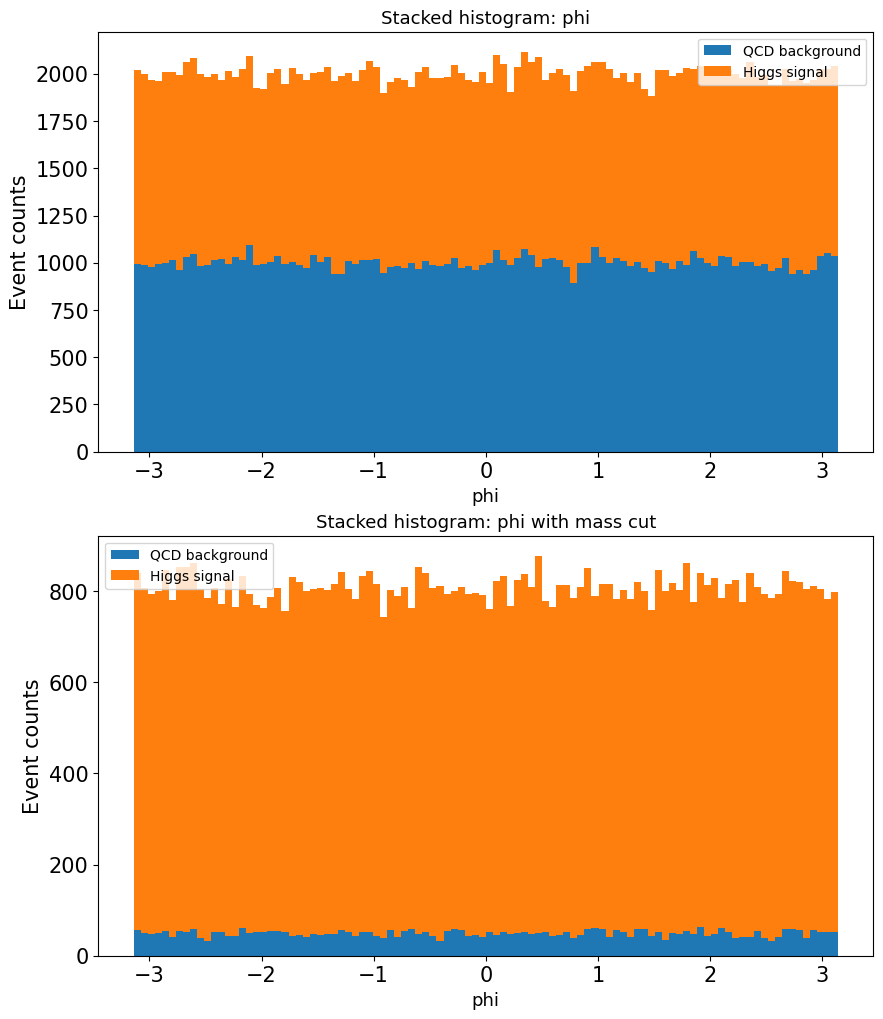

In [28]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'phi', 'mass')

With phi, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range, in addition to the data composition looking almost identical. This suggests there is very low discriminatory power for slicing based on phi.

The phi Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on phi as the data range entirely overlaps.

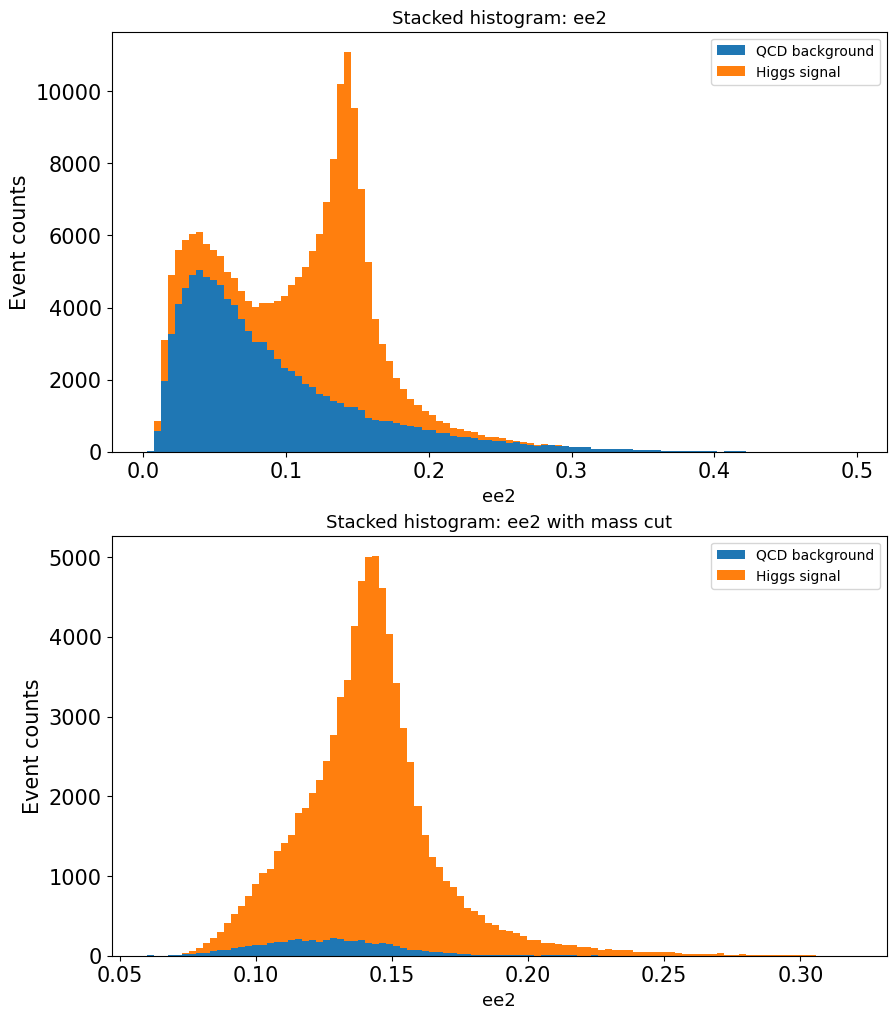

In [29]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee2', 'mass')

With ee2, I observe that the feature's Set A plot has Higgs signal and QCD background data in approximately the same range, however the peak for the Higgs signal is noticeably different from that of the QCD background data. This suggests there is some discriminatory power for slicing based on ee2. I could make a slice of data to keep that in the range of 0.1 to 0.2 while cutting out the majority of the background data and keeping the majority of the Higgs signal data.

The ee2 Set B plot shows the stacked histogram of the datasets after the mass cut. The Higgs signal and QCD background data overlap significantly, therefore I don't think I could improve upon the expected significance by making a further cut on ee2.

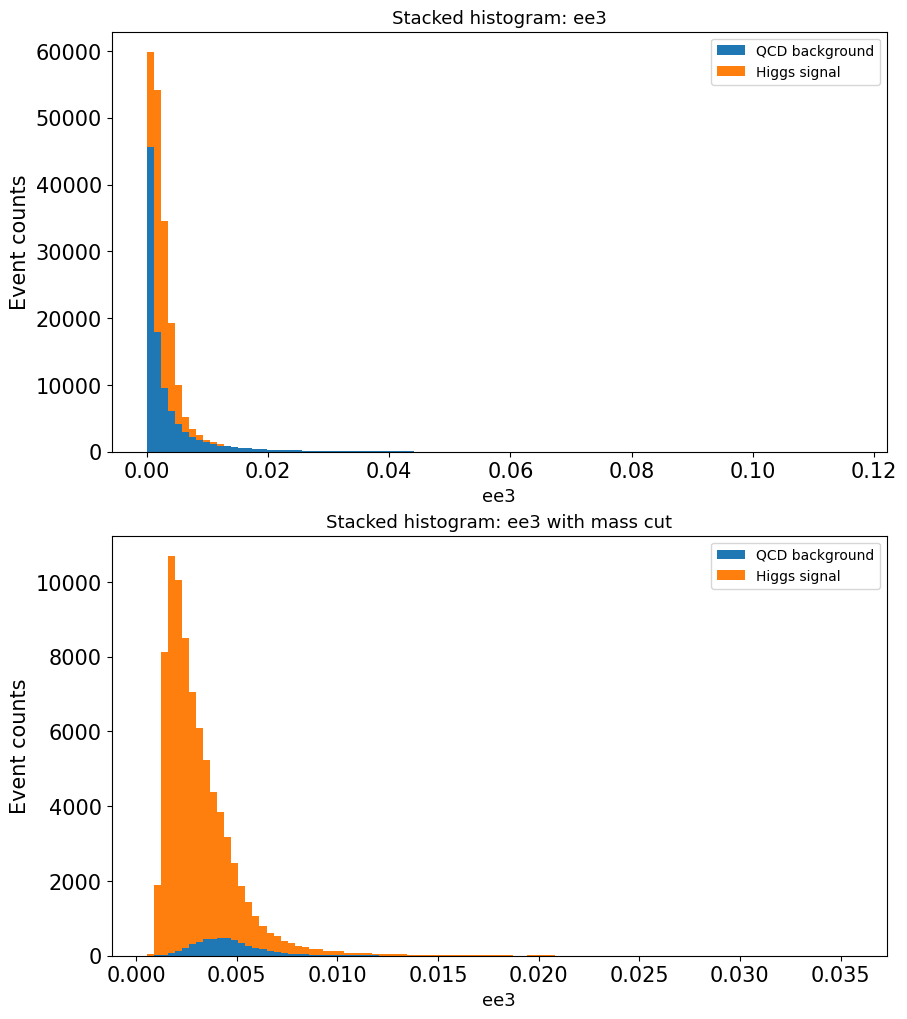

In [30]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'ee3', 'mass')

With ee3, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on ee3.

The ee3 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on ee3 as the data range significantly overlaps.

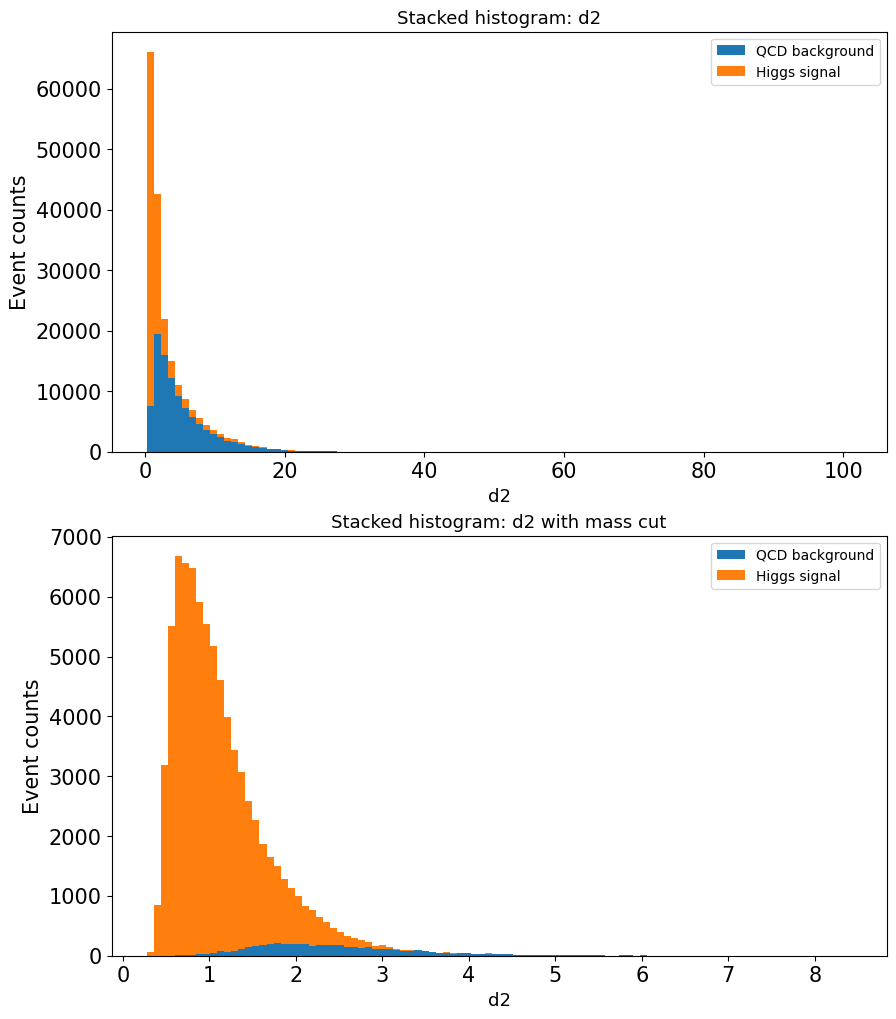

In [31]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'd2', 'mass')

With d2, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on d2.

The d2 Set B plot shows the stacked histogram of the datasets after the mass cut. We can improve upon the expected significance by making a further cut on d2: consider, for example, a further slice of the data to keep only that which has d2 within the range of 0 and 2.5. This would keep the majority of the Higgs data while removing the majority of the QCD background data.

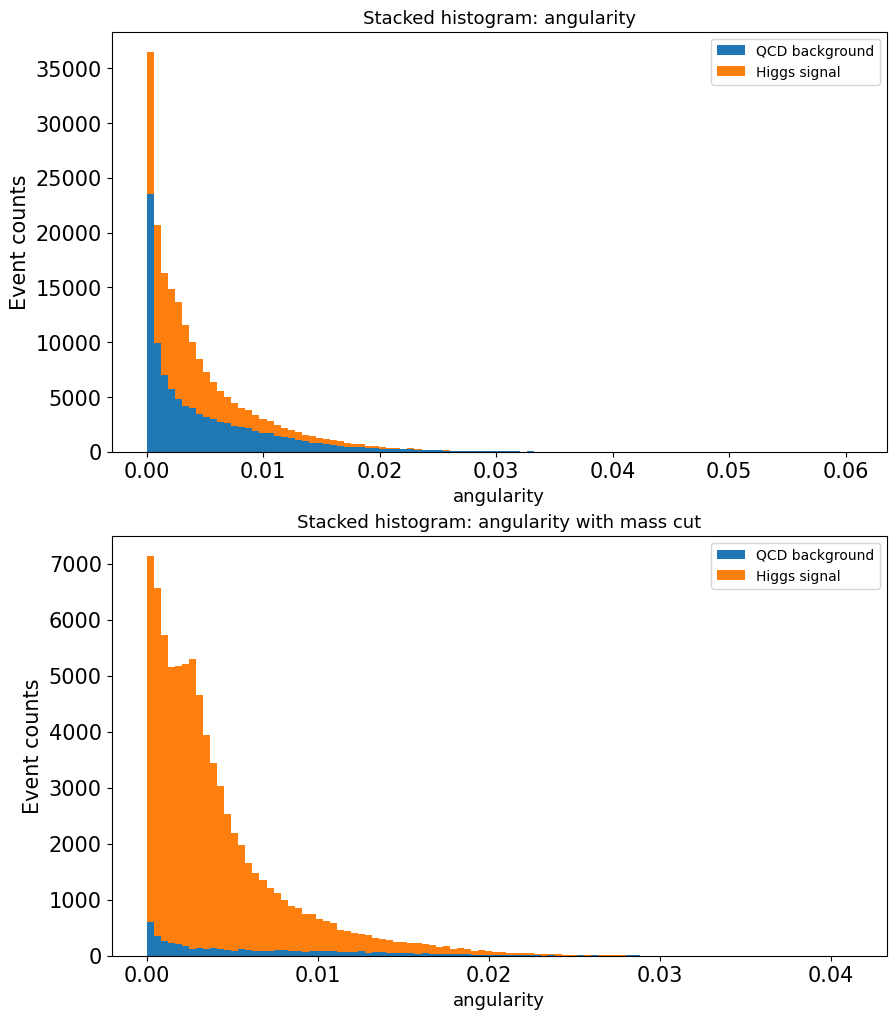

In [32]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'angularity', 'mass')

With angularity, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on angularity.

The angularity Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on angularity as the data range entirely overlaps.

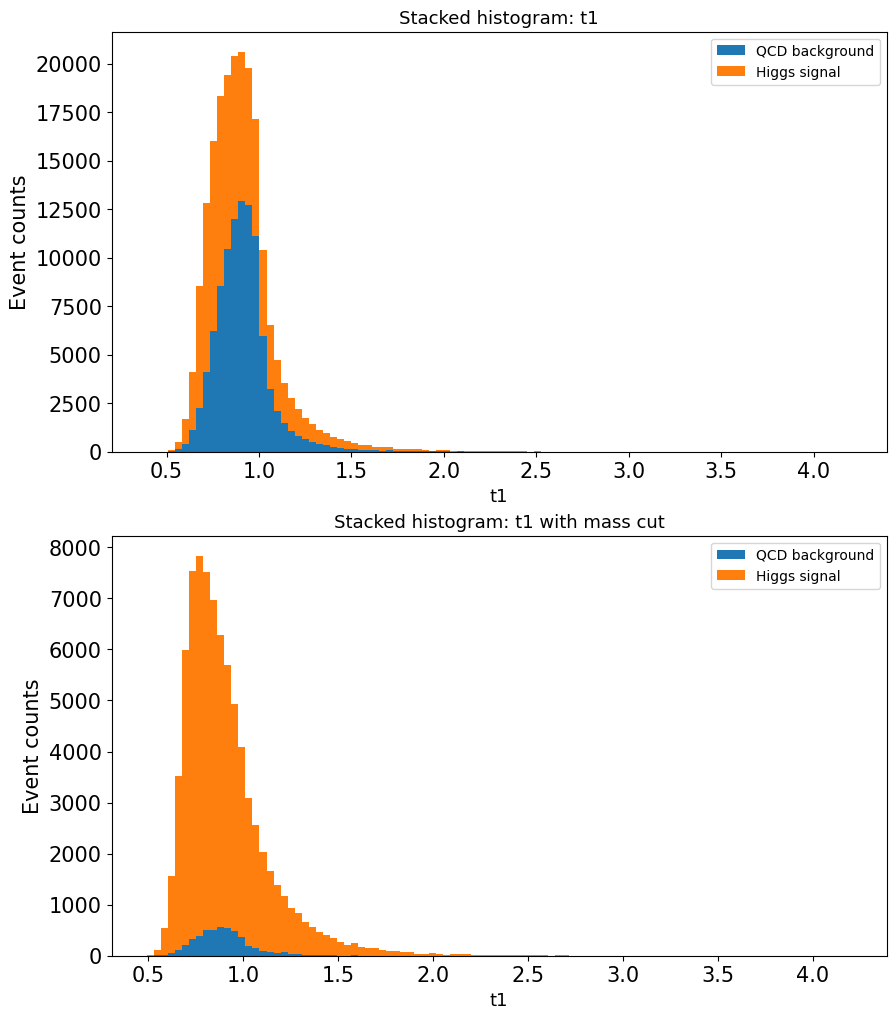

In [33]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't1', 'mass')

With t1, I observe that the feature's Set A plot has Higgs signal and QCD background data in almost exactly the same range, suggesting there is very low discriminatory power for slicing based on t1.

The t1 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on t1 as the data range significantly overlaps.

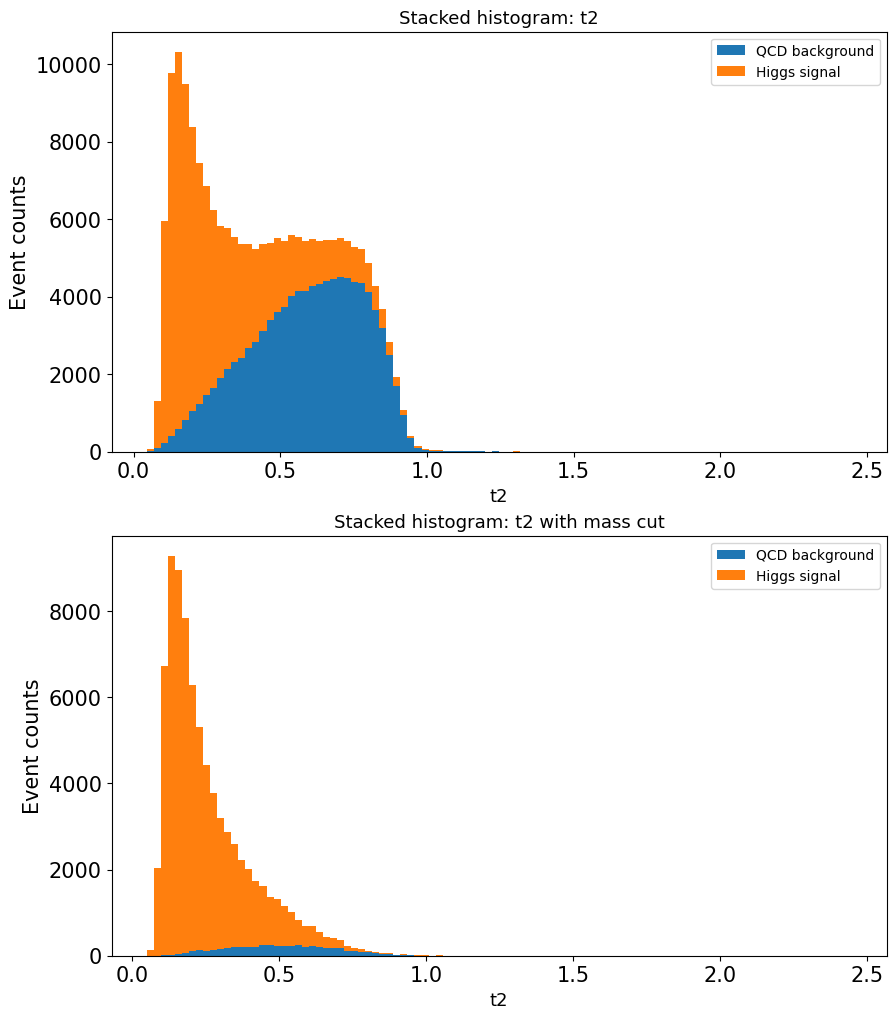

In [34]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't2', 'mass')

With t2, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.1, while the QCD background peaks around 0.75. There is some discriminatory power for slicing based on t2, for example we could make a slice to keep data only within the range of 0 and 0.5 (but we may lose a fraction of the Higgs signal data).

The t2 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t2 by slicing to keep data only within the range of 0 and 0.5, same as for Set A.

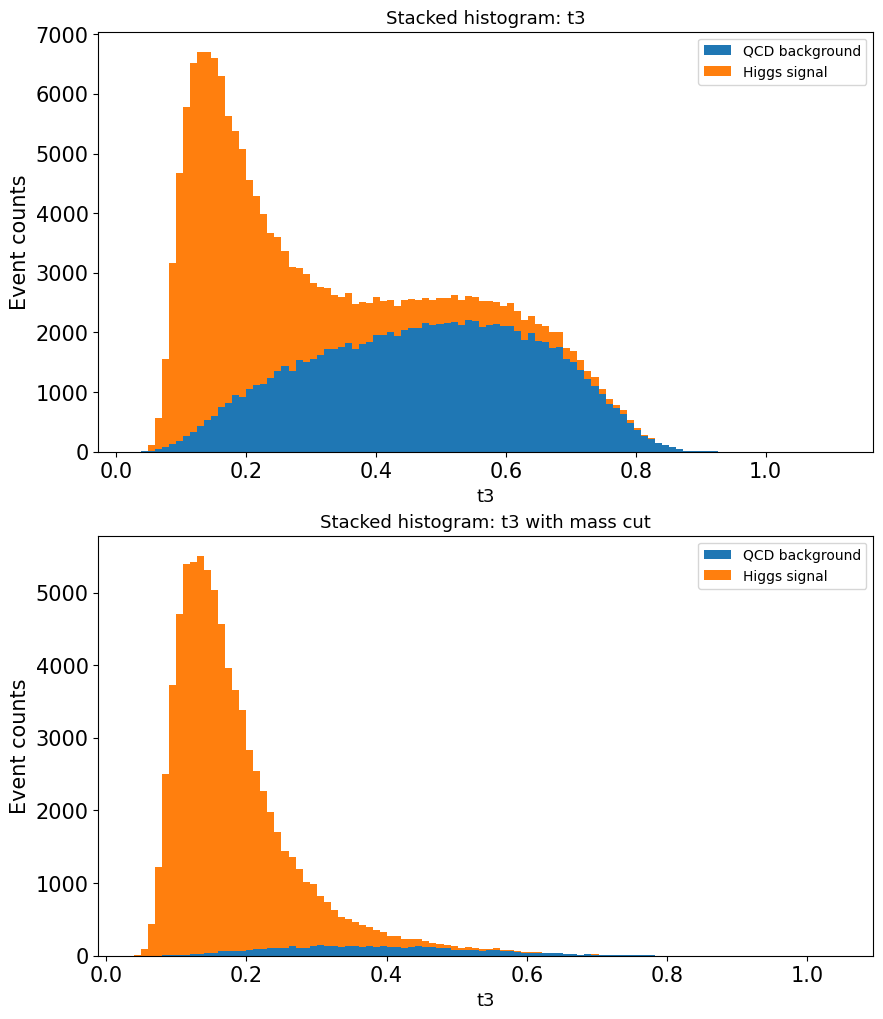

In [35]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't3', 'mass')

With t3, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.15, while the QCD background peaks around 0.5. There is some discriminatory power for slicing based on t3, for example we could make a slice to keep data only within the range of 0 and 0.5 (but we may lose a fraction of the Higgs signal data).

The t3 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t3 by slicing to keep data only within the range of 0 and 0.5, same as for Set A.

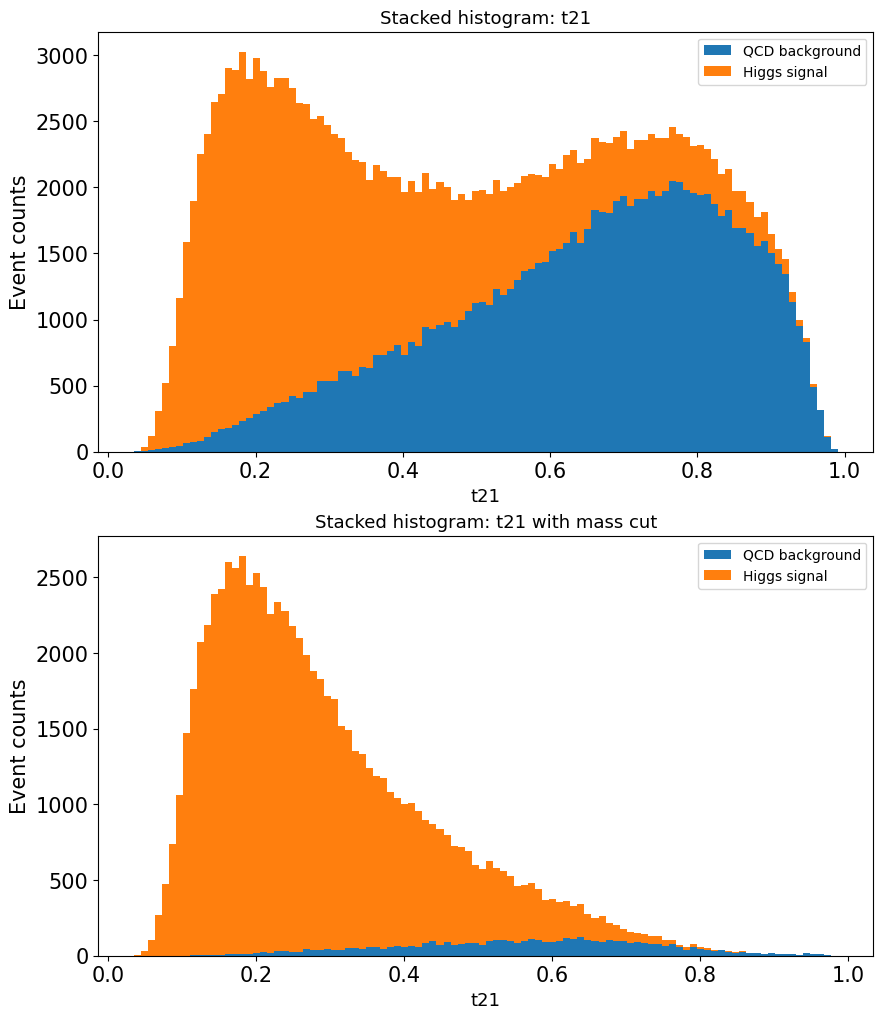

In [36]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't21', 'mass')

With t21, I observe that the feature's Set A plot shows Higgs signal and QCD background data with two very different peaks. The Higgs signal data peaks around 0.2, while the QCD background peaks around 0.8. There is some discriminatory power for slicing based on t21, for example we could make a slice to keep data only within the range of 0 and 0.6 (but we may lose a fraction of the Higgs signal data).

The t21 Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance, I can make a further cut on t21 by slicing to keep data only within the range of 0 and 0.6, same as for Set A. This would remove approximately half of the qcd background data.

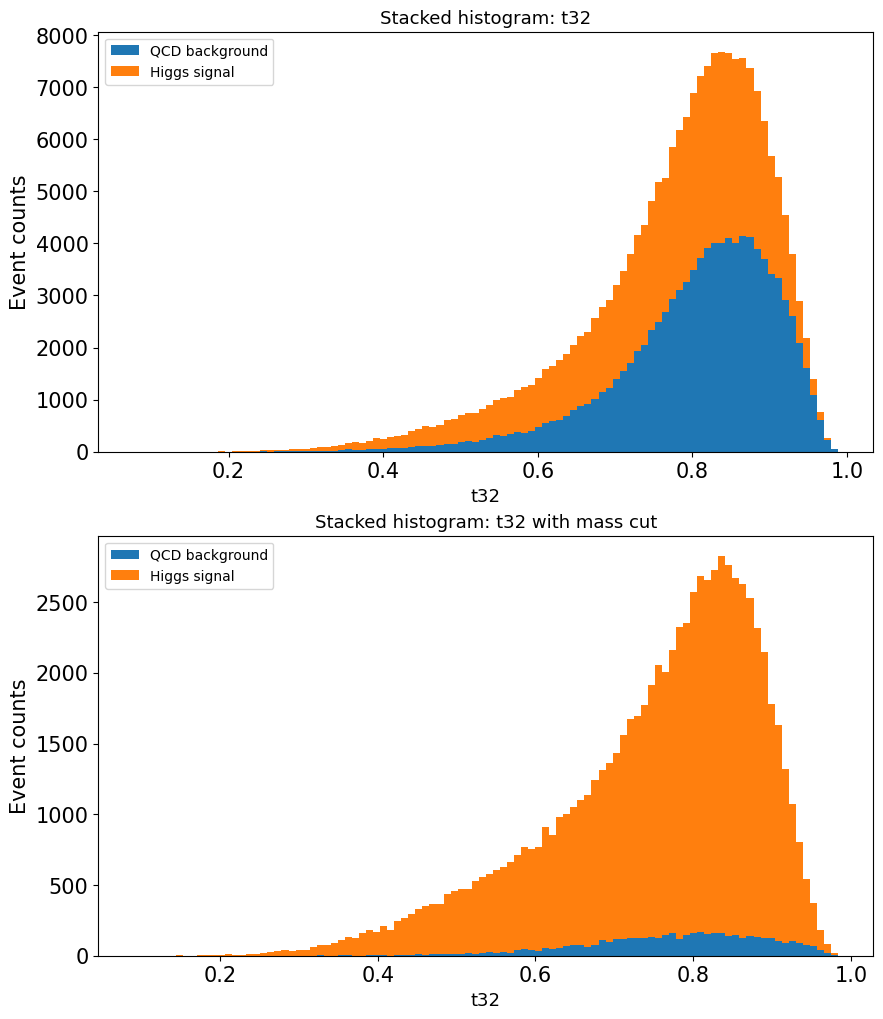

In [37]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 't32', 'mass')

With t32, I observe that the feature's Set A plot shows Higgs signal and QCD background data with overlapping peaks at approximately 0.85. There is very low discriminatory power for slicing based on t32.

The t32 Set B plot shows the stacked histogram of the datasets after the mass cut. I don't see a way to improve upon the expected significance by making a further cut on t32 as the data range entirely overlaps.

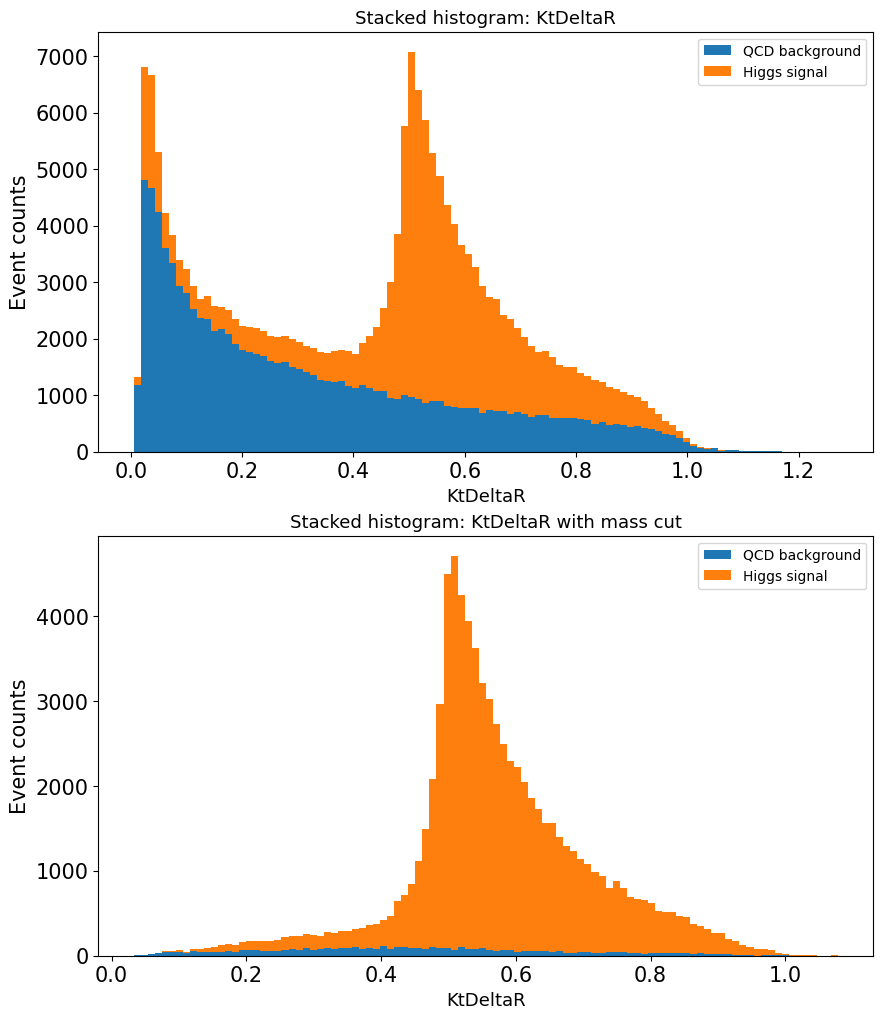

In [38]:
plot_comparison(qcd_dict, higgs_dict, output[0], output[1], 'KtDeltaR', 'mass')

With KtDeltaR, I observe that the feature's Set A plot shows Higgs signal and QCD background data with one small overlapping peak at approximately 0.05, and an additional peak in the Higgs signal data around 0.5. There is some discriminatory power for slicing based on KtDeltaR. Consider a slice that keeps data where KtDeltaR is between 0.4 and 1.0. This would keep the majority of the Higgs signal data while removing around half of the background data.

The KtDeltaR Set B plot shows the stacked histogram of the datasets after the mass cut. To improve upon the expected significance I can make a further cut on KtDeltaR by slicing to keep data within the range of 0.4 and 1.0. As in Set A, this would keep the majority of the Higgs signal data while removing around half of the background data.

##### Summary of Observations
Set A plots with very little or no discriminatory power include pt, eta, phi, ee3, d2, angularity, t1, and t32.

Set A plots with some discriminatory power, but less than mass include ee2, t2, t3, t21, KtDeltaR. I found that no Set A plots had equal discriminatory power as mass. With the feature cut on mass, I was able to remove 95.1% of the QCD background data with my slicing, however with the other plots with some discriminatory power between the Higgs signal and the QCD background data, I could only remove at maximum around half of the QCD background while keeping an adequate portion of Higgs signal data.

From the Set B plot observations, I identified that making further slices on the features of d2, angularity, t2, t3, t21, and KtDeltaR after the initial cut on mass would each improve my expected significance.

## Part 4
Next, I will use multiple features to optimize event selections. I will take the information I obtained in Part 3 to make further cuts on the mass-sliced data. My goal is to achieve a significance of 5 sigma.

I will start by making a further slice on the feature of d2. Afterwards, if I still have not reached 5 sigma significance I will decide then to make further cuts (on 1 of the 4 leftover variables). If I have reached 5 sigma significance, then there is no need to go further.

In [39]:
# Recall for the mass cut we used, data is stored in the variable 'output' in the following order:
    # new_qcd, new_higgs, y_qcd, y_higgs, sigma, perc_qcd, perc_higgs

def slice_mass_on_d2(low_d2, high_d2):
    output_d2 = slice_data(output[0], output[1], 'd2', low_d2, high_d2, True)
    print(f'For a d2 cut keeping data between {low_d2} and {high_d2}, I obtain a significance of {output_d2[4]:.4f} sigma.')
    print(f'Higgs % data kept: {output_d2[6]*100:.2f}%')
    print(f'Background % kept: {output_d2[5]*100:.2f}%')

slice_mass_on_d2(0,2.5)
slice_mass_on_d2(0,2)
slice_mass_on_d2(0,1.8)
slice_mass_on_d2(0,1.3)
slice_mass_on_d2(0,1.6)
slice_mass_on_d2(0,1.4)

For a d2 cut keeping data between 0 and 2.5, I obtain a significance of 3.0474 sigma.
Higgs % data kept: 74.87%
Background % kept: 2.88%
For a d2 cut keeping data between 0 and 2, I obtain a significance of 3.6856 sigma.
Higgs % data kept: 71.76%
Background % kept: 1.78%
For a d2 cut keeping data between 0 and 1.8, I obtain a significance of 4.1766 sigma.
Higgs % data kept: 69.22%
Background % kept: 1.28%
For a d2 cut keeping data between 0 and 1.3, I obtain a significance of 6.4266 sigma.
Higgs % data kept: 56.31%
Background % kept: 0.31%
For a d2 cut keeping data between 0 and 1.6, I obtain a significance of 4.8464 sigma.
Higgs % data kept: 65.64%
Background % kept: 0.82%
For a d2 cut keeping data between 0 and 1.4, I obtain a significance of 5.9679 sigma.
Higgs % data kept: 60.10%
Background % kept: 0.43%


I started with my initial range guess of 0 to 2.5, then manually selected narrower ranges to optimize my sigma value. While maximizing my significance is one goal, the other goal is to keep as much of the Higgs signal data as I could.

If I go with a cut on d2 between 0 and 1.3, this would result in the highest significance of 6.4266 sigma but this also results in the most data lost. For the sake of event selection I would like to try to preserve as much data as I can while still resulting in a significance of over 5 sigma. This means taking the d2 cut of between 0 and 1.4 would be best as this results in a significance of 5.9679 which keeps 60.1% of the original Higgs dataset and 0.43% of the original QCD background.

My final process of event selection that I have established in this lab is to cut on mass between 120 and 130 GeV, then cut on d2 between 0 and 1.4. This results in keeping 60.1% of the Higgs dataset, 0.43% of the QCD background dataset, and a significance of 5.9679.

##### Comparison of Significance with William Olsen
My lab partner William Olsen used a different pT sample dataset. He started with 100k QCD background events and 100k Higgs signal events as well, all simulated. However, he had different expected yields before cutting; William's datasets had 50 expected Higgs signal events and 2000 expected QCD background events. He calculated an initial significance of 1.1282 sigma. After slicing his dataset on the features of mass, t3, then KtDeltaR in this order, he was able to optimize his significance to 5.5542 sigma, keeping 90.37% of the Higgs dataset he originally had, and 2.73% of the initial QCD background.

In comparison, both William and I were able to optimize our event selections to obtain significance over 5 sigma, the discovery threshold that is standard in physics. However, William was able to preserve 90.37% of the Higgs signal data, much greater than the 60.1% of my Higgs signal data.

# Lab 8: Pseudo-experiment data analysis

## Introduction

In this lab, we will use the optimized event selection found in Lab 7 to hunt for my signal with the pseudo-experiment datasets. These come in two files: one that contains high luminosity data, and one for low luminosity data. Both of these luminosity data files have transverse momentum (pt) in the same range as my simulation data, from 250 to 500.

The high luminosity data is associated with a higher number of collisions that occur in a given amount of time than the low luminosity data.

First, we'll need to load the pseudo-experiment data. I use the library pandas to read the hdf files.

In [40]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
import h5py
import math
import pickle

# open the qcd background data file, and use pickle loading
infile = open("qcd250-500.pkl",'rb')
qcd_dict = pickle.load(infile)

# open the higgs signal data file, and use pickle loading
infile = open("higgs250-500.pkl",'rb')
higgs_dict = pickle.load(infile)

import pandas
highLumi = pandas.read_hdf('data_highLumi_pt_250_500.h5')
lowLumi = pandas.read_hdf('data_lowLumi_pt_250_500.h5')

# set fig size
plt.rcParams["figure.figsize"] = (10,12)

## Part 1
For each feature of my event selection (mass and d2), I will plot the observed data and overlap this with a plot of the expected signal and background data (as a stacked histogram) which are normalized to the observed yields. I will do this before event selection and after to show the effect of my event selection.

Afterward, I will evaluate the observed significance that results and compare my results to the expectation. 

We'll start with the high luminosity dataset first. Let's see how many events are included in this dataset.

In [41]:
N_highLumi = len(highLumi) 
print(N_highLumi)

40344


The high luminosity dataset has 40,344 events recorded.

To overlap the plots, I will need to take my qcd and higgs data and scale it by two factors: 
- one to reflect the ratio of the expected yields of the higgs signal to the qcd background: 100/20,100 and 20,000/20,100 respectively
- one to normalize the expected signal and background data to the observed yields. This will be the same ratio for both: 40,344/100,000 such that the plots reflect the same number of total events (observed and expected are the same).

My event selection as determined in Lab 7 uses two features: mass and d2. I will plot the observed high luminosity data for both of these features overlapped with the expected signal and background, before and after event selection.

First I will start with mass:

In [58]:
def calc_sigma_poisson(lam, signal):
    prob = stats.poisson.sf(signal, lam)
    sigma = stats.norm.isf(prob)
    
    return sigma

def slice_data(qcd, higgs, lumi, var, low, high):
    # slice qcd
    ind_qcd_below = qcd[qcd[f'{var}'] < low].index
    ind_qcd_above = qcd[qcd[f'{var}'] > high].index
    new_qcd = qcd.drop(ind_qcd_below)
    new_qcd = new_qcd.drop(ind_qcd_above)
    
    # slice higgs
    ind_higgs_below = higgs[higgs[f'{var}'] < low].index
    ind_higgs_above = higgs[higgs[f'{var}'] > high].index
    new_higgs = higgs.drop(ind_higgs_below)
    new_higgs = new_higgs.drop(ind_higgs_above)
    
    # slice lumi
    ind_lumi_below = lumi[lumi[f'{var}'] < low].index
    ind_lumi_above = lumi[lumi[f'{var}'] > high].index
    new_lumi = lumi.drop(ind_lumi_below)
    new_lumi = new_lumi.drop(ind_lumi_above)
    
    return new_qcd, new_higgs, new_lumi

def plot_comp(lumi, var):
    # Plot data before slicing:
    # Combine histograms to plot stacked
    combined = [qcd_dict[f'{var}'], higgs_dict[f'{var}']]
    # Scaling ratios for qcd and higgs expected yields
    R_higgs = 100/20100 # exp yields of simulated data are given
    R_qcd = 20000/20100
    # Scale to observed yields
    R_scale = len(lumi) / 100000 # both qcd and higgs have 100k events
    # Plot stacked histogram for qcd background and higgs signal
    weights_qcd = np.full(100000, R_qcd * R_scale)
    weights_higgs = np.full(100000, R_higgs * R_scale)
    plt.subplot(2,1,1)
    plt.hist(combined, bins = 100, density=False, weights = [weights_qcd, weights_higgs], histtype='bar', stacked = True, label = ['QCD expected yields', 'Higgs expected yields'])
    # Plot high lumi observed data
    obs_hist, edges = np.histogram(lumi[f'{var}'], bins = 100)
    plt.stairs(obs_hist, edges = edges, fill = False, linewidth = 2, color = 'r', label = 'Observed data')
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Number of events', fontsize = 15)
    plt.title(f'Histogram: {var} before event selection', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()

    # Slice data
    qcd_sliced, higgs_sliced, lumi_sliced = slice_data(qcd_dict, higgs_dict, lumi, 'mass', 120, 130)
    qcd_sliced, higgs_sliced, lumi_sliced = slice_data(qcd_sliced, higgs_sliced, lumi_sliced, 'd2', 0, 1.4)
    
    # Plot sliced data:
    plt.subplot(2,1,2)
    combined_sliced = [qcd_sliced[f'{var}'], higgs_sliced[f'{var}']]
    N_exp_sliced = (len(qcd_sliced) * R_qcd) + (len(higgs_sliced) * R_higgs)
    R_higgs_sliced = (len(higgs_sliced) * R_higgs) / N_exp_sliced
    R_qcd_sliced = (len(qcd_sliced) * R_qcd) / N_exp_sliced
    # Scale to observed yields
    weights_qcd_sliced = np.full(len(qcd_sliced), R_qcd_sliced * len(lumi_sliced) / len(qcd_sliced))
    weights_higgs_sliced = np.full(len(higgs_sliced), R_higgs_sliced * len(lumi_sliced) / len(higgs_sliced))
    # plot stacked histogram for qcd background and higgs signal
    plt.hist(combined_sliced, bins = 100, density=False, weights = [weights_qcd_sliced, weights_higgs_sliced], histtype='bar', stacked = True, label = ['QCD expected yields', 'Higgs expected yields'])
    # plot observed data
    obs_hist_sliced, edges_sliced = np.histogram(lumi_sliced[f'{var}'], bins = 100)
    plt.stairs(obs_hist_sliced, edges = edges_sliced, fill = False, linewidth = 2, color = 'r', label = 'Observed data')
    plt.xlabel(f'{var}', fontsize = 13)
    plt.ylabel('Number of events', fontsize = 15)
    plt.title(f'Histogram: {var} after event selection', fontsize = 13)
    plt.tick_params(labelsize=15)
    plt.legend()
    plt.show()

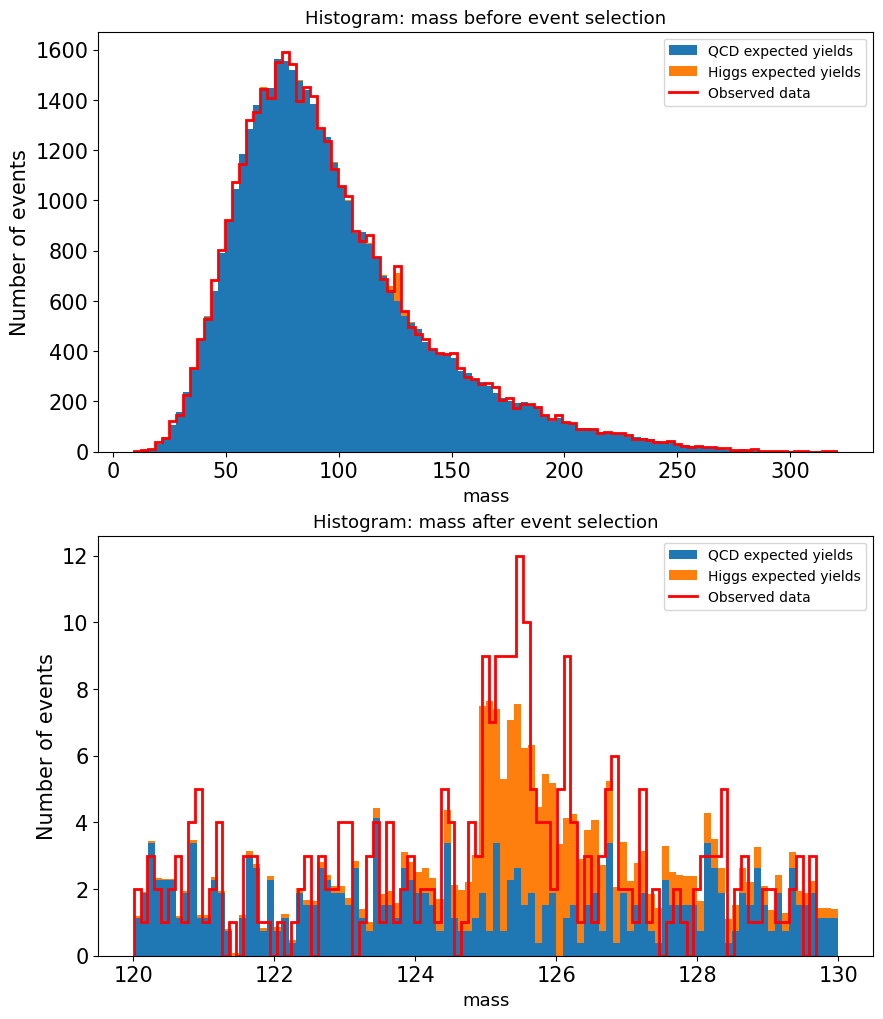

In [59]:
plot_comp(highLumi, 'mass')

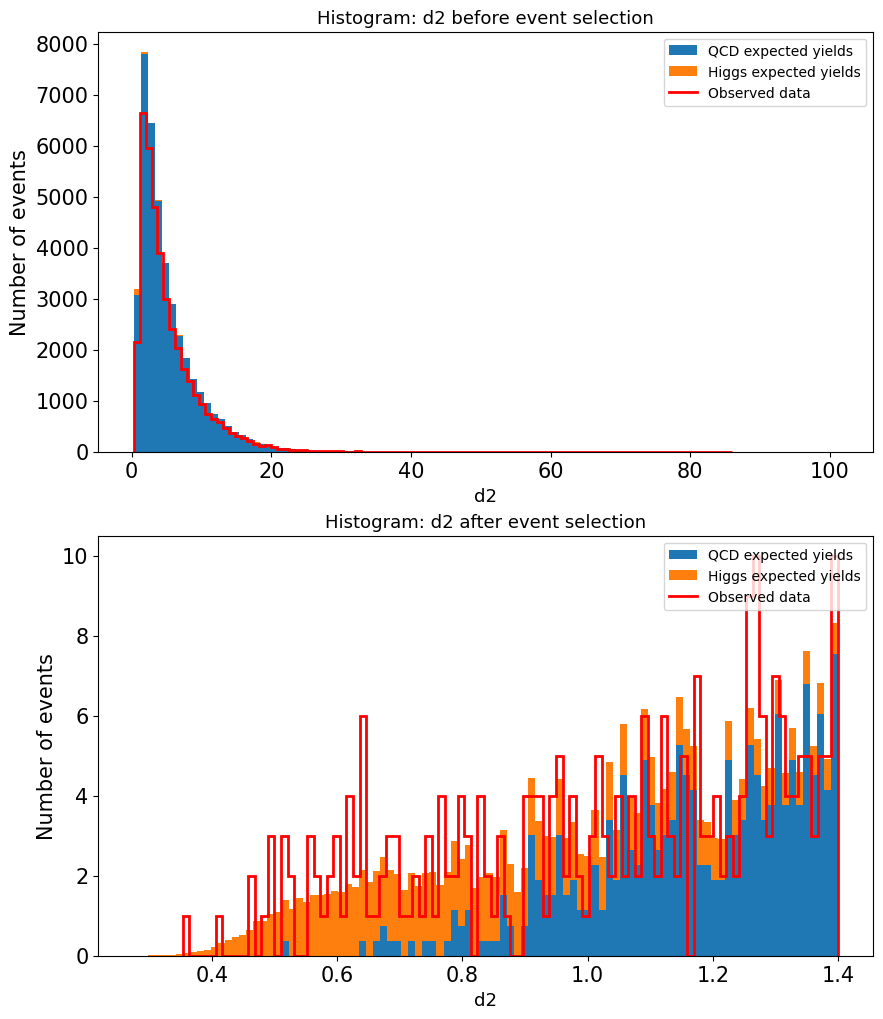

In [60]:
plot_comp(highLumi, 'd2')

Before event selection, I can see that the mass feature of the observed data overlaps well with the expected signal and background data. After event selection, it appears to overlap with the combination of stacked signal and background data overall, but the part which overlaps consists of more Higgs signal data than before event selection. I see this same result for the d2 feature.

Next, I would like to mathematically determine the observed significance after event selection and compare this with my expectation.

The statistical question that I would like to answer is the following: __What is the significance of my observation given the background is Poisson-distributed, where a stronger signal is achieved with an observation of more events?__

The Poisson-distributed background has a lambda parameter equal to the expected yield of the QCD background array after event selection. The observation is equal to the number of events in the observed data after event selection.

In [67]:
# Calculate the parameter lambda of the background
qcd_sliced, higgs_sliced, highLumi_sliced = slice_data(qcd_dict, higgs_dict, highLumi, 'mass', 120, 130)
qcd_sliced, higgs_sliced, highLumi_sliced = slice_data(qcd_sliced, higgs_sliced, highLumi_sliced, 'd2', 0, 1.4)
lam = int(len(qcd_sliced) * 0.2) # ratio given in Lab 7
print(f'After event selection there are {lam} expected QCD background events.')

# Observation is the length of lumi array after event selection
signal_highLumi = len(highLumi_sliced)
print(f'The observation is {signal_highLumi} events.')

# Calculate significance of this observation
prob = stats.poisson.sf(signal_highLumi, lam)
sigma_highLumi = stats.norm.isf(prob)
print(f'The significance of my observation of high luminosity events after event selection is {sigma_highLumi:.4f} sigma.')

After event selection there are 85 expected QCD background events.
The observation is 275 events.
The significance of my observation of high luminosity events after event selection is 16.3527 sigma.


From my calculations, my null hypothesis is an expected yield of 85 QCD background events after event selection. If we assume the null hypothesis of getting 85 QCD background events, then upon measuring 275 events the significance of this is 16.3527$\sigma$. This is far greater than the 5$\sigma$ needed to claim discovery of the Higgs boson.

## Part 2
Next we will do the same procedure for the low luminosity dataset. I will first count the number of events in the dataset, then I will plot the observed data overlapping with the expected yields of signal and qcd background, first before and then after event selection. I will also calculate the observed significance and then I would like to compare this with the high luminosity dataset.

In [68]:
N_lowLumi = len(lowLumi)
print(N_lowLumi)

4060


The low luminosity dataset has 4,060 events. This is about ten times smaller than the high luminosity dataset, which means there is not as much information. There is likely to be fewer qcd background events and higgs signal events in the observed low luminosity data as a result.

Next let us plot the comparison before and after event selection for mass, and d2 the two event selection features.

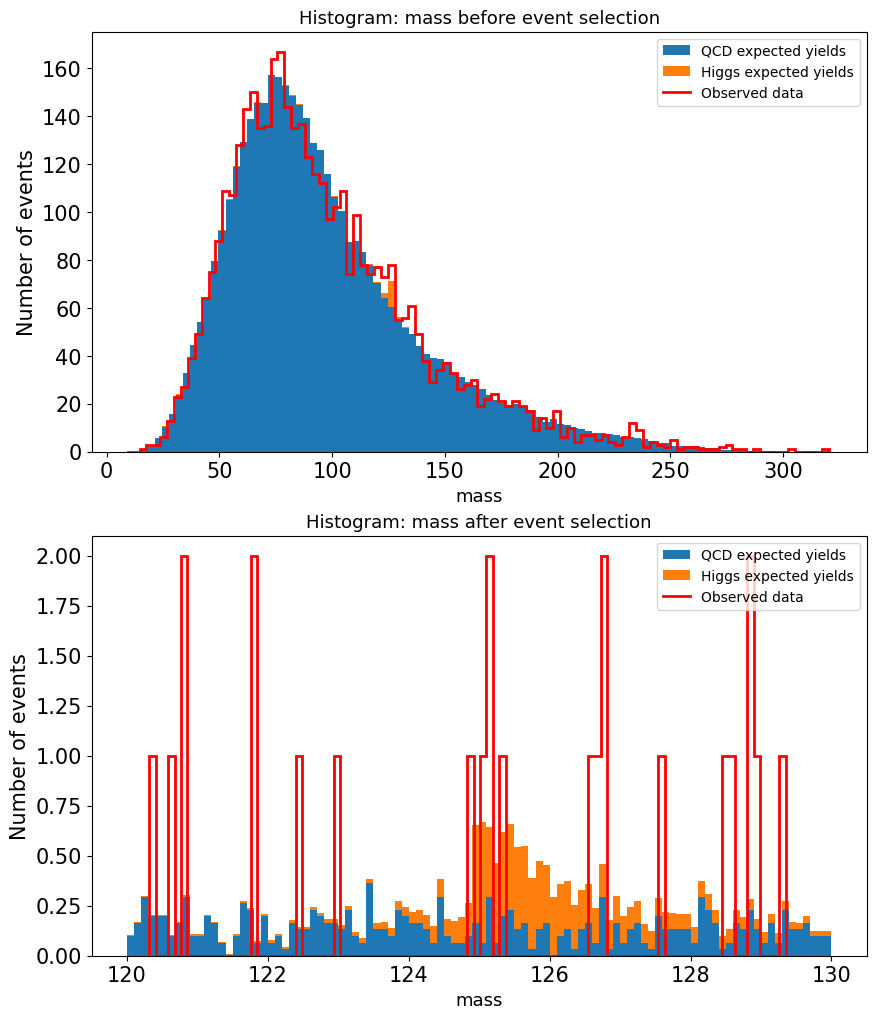

In [69]:
plot_comp(lowLumi, 'mass')

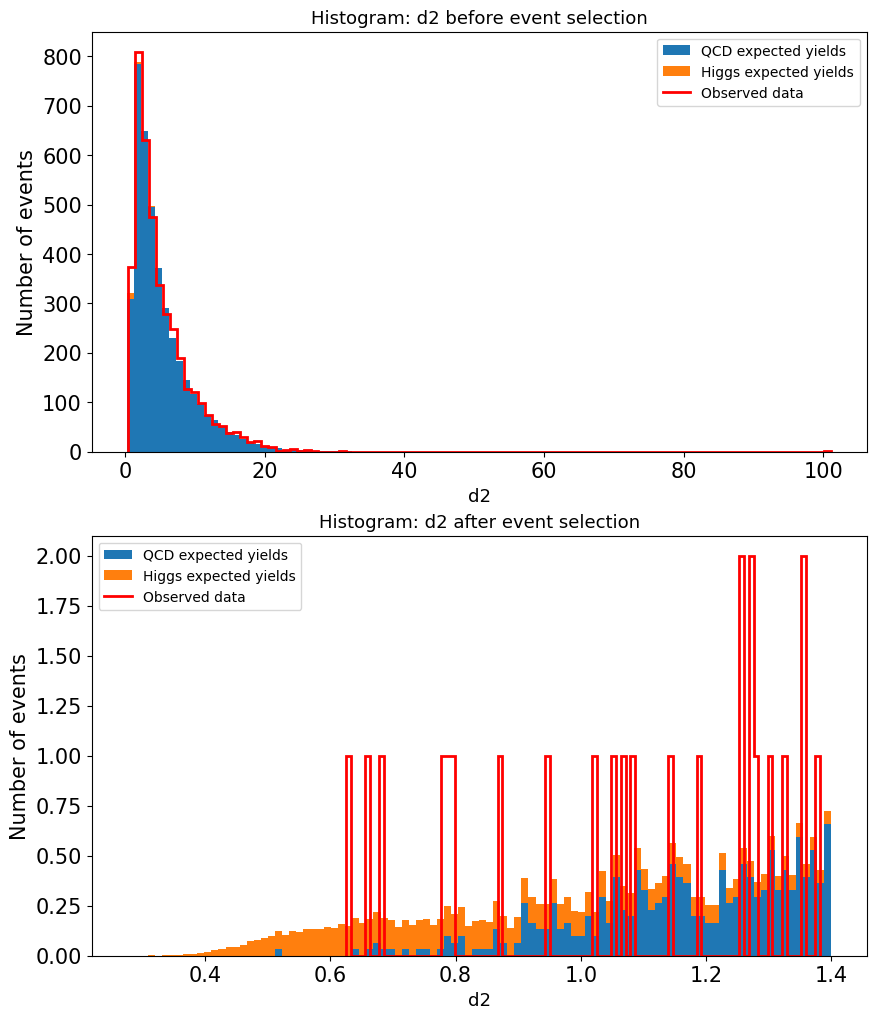

In [70]:
plot_comp(lowLumi, 'd2')

Prior to event selection, I can see that the mass feature of the observed low luminosity data overlaps fairly well with the expected signal and background data. After event selection, it does not appear to overlap at all with the combination of stacked signal and background data. I see this same result for the d2 feature.

Now I would like to determine the observed significance after event selection and compare this with my expectation.

The statistical question that I would like to answer is the following: __What is the significance of my observation given the background is Poisson-distributed, where a stronger signal is achieved with an observation of more events?__

The Poisson-distributed background has a lambda parameter equal to the expected yield of the QCD background array after event selection. The observation is equal to the number of events in the observed data after event selection.

In [72]:
# Calculate the parameter lambda of the background
qcd_sliced, higgs_sliced, lowLumi_sliced = slice_data(qcd_dict, higgs_dict, lowLumi, 'mass', 120, 130)
qcd_sliced, higgs_sliced, lowLumi_sliced = slice_data(qcd_sliced, higgs_sliced, lowLumi_sliced, 'd2', 0, 1.4)
lam = int(len(qcd_sliced) * 0.2) # ratio given in Lab 7
print(f'After event selection there are {lam} expected QCD background events.')

# Observation is the length of lumi array after event selection
signal_lowLumi = len(lowLumi_sliced)
print(f'The observation is {signal_lowLumi} events.')

# Calculate significance of this observation
# sigma_lowLumi = calc_sigma_poisson(lambda_lowLumi, signal_lowLumi)
prob = stats.poisson.sf(signal_lowLumi, lam)
sigma_lowLumi = stats.norm.isf(prob)
print(f'The significance of my observation of low luminosity events after event selection is {sigma_lowLumi:.4f} sigma.')

After event selection there are 85 expected QCD background events.
The observation is 24 events.
The significance of my observation of low luminosity events after event selection is -7.7285 sigma.


From my calculations, my null hypothesis is an expected yield of 85 QCD background events after event selection. If we assume the null hypothesis of getting 85 QCD background events, then upon measuring 24 events, where a stronger signal is given by greater number of events, the significance of this is negative and has a fairly large magnitude. Therefore, our measurement is not significant.

This is a big difference between the high luminosity and low luminosity datasets. Note that the original high luminosity dataset contained approximately ten times the amount of data that the original low luminosity dataset did. This is likely the biggest reason why there is such a big difference in the statistical significance of these observations.

Let us also calculate the percentage of data remaining in the high and low luminosity datasets after event selection, and compare this to our null hypothesis, which is the percentage of QCD events remaining after event selection.

In [73]:
perc_qcd = len(qcd_sliced) / len(qcd_dict)
perc_highLumi = len(highLumi_sliced) / len(highLumi)
perc_lowLumi = len(lowLumi_sliced) / len(lowLumi)

print(f'The percentage of qcd background events leftover after event selection is {perc_qcd*100:.3f}%.')
print(f'The percentage of high luminosity events leftover after event selection is {perc_highLumi*100:.3f}%.')
print(f'The percentage of low luminosity events leftover after event selection is {perc_lowLumi*100:.3f}%.')

The percentage of qcd background events leftover after event selection is 0.429%.
The percentage of high luminosity events leftover after event selection is 0.682%.
The percentage of low luminosity events leftover after event selection is 0.591%.


As we can see, the event selection removed almost all of the data for both high and low luminosity datasets, as was the case in our null hypothesis where we kept 0.429% of the qcd background data. Therefore, the event selection results went accordingly with our expectations.

Approximately the same percentage of data was removed in the high and low luminosity datasets, but as stated before, the size of the datasets were very different. The high luminosity dataset is much larger, which results in a greater amount of expected qcd background and higgs signal events and likely captured more of the complexities of the feature measurements. It is therefore unsurprising that the high luminosity observation after event selection is very significant and would allow us a claim of discovery, but the low luminosity observation after event selection is not significant and doesn't provide us _as much_ valuable information about the Higgs signal. 

## Part 3
In this next part of the lab I would like to evaluate the 95% confidence level of the signal yields. In the low luminosity data, the observed significance is less than 5$\sigma$. Because I did not see a significant observation with the luminosity data, my question now becomes: How faint must the Higgs signal have been for me not to see it? I can answer this question by calculating the 95% confidence level upper limit (X) of the signal yield. In other words, if the signal was stronger than this value X, I would see it 95% of the time.

To find this 95% confidence level upper limit, I will need to complete the following procedure:
- First I will construct a 2D histogram of the simulated observations, where the x axis represents the possible observed signals, and the y axis represents the possible true signals. I will plot a vertical line where my observation is. This observation is equal to expected yield for signal and background after event selection (for the expected 95% confidence level upper limit) and the number of observed events from the low luminosity data after event selection (for the observed 95% confidence level upper limit).
- Next I will take horizontal slices from where a true signal of 0 is, and increase this true signal level until I find the point where the observed signal is at the 95% probability level. This involves an integral of the true signal probability distribution, from the observed number of events to infinity.

In [74]:
# calculate expected signal + background observation
exp_higgs = int(len(higgs_sliced) * 0.001)
exp_data = exp_higgs + lam
print(f'The expected yield of higgs signal with qcd background events is {exp_data} events.')

The expected yield of higgs signal with qcd background events is 145 events.


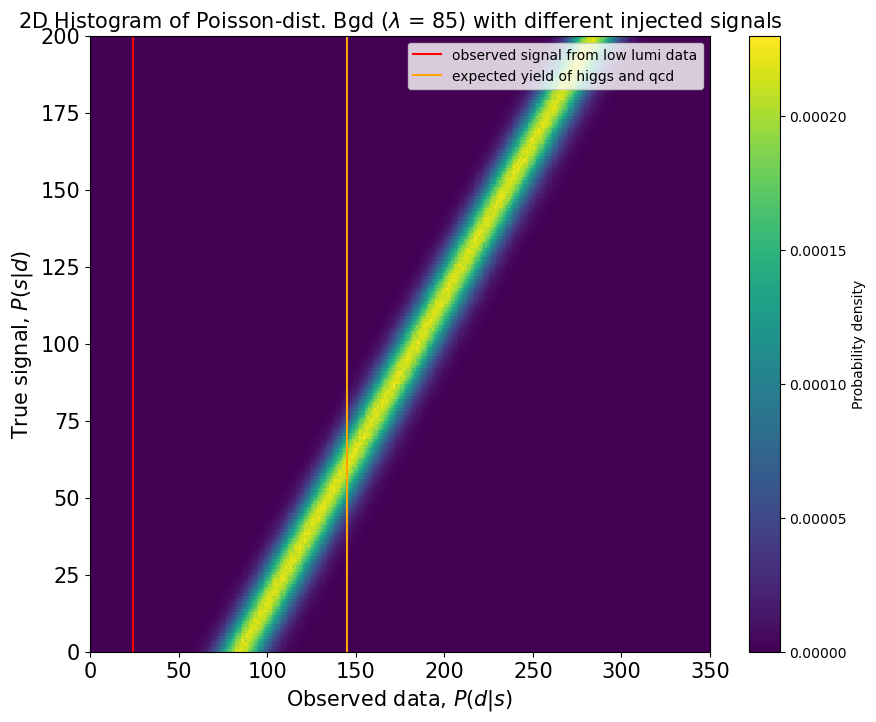

In [79]:
# change fig size
plt.rcParams["figure.figsize"] = (10,8)

# define background data and inj_signal as an array
num_draws = 10000000 #10 million draws
bkgd_exp = stats.poisson.rvs(lam, size=num_draws) # expected qcd background has lambda = 85 events

# define injected signals
signals = np.random.randint(0, 200, num_draws)

# Add signal to background
data2 = bkgd_exp + signals

# prepare axes for 2d histogram
# observed signals (data) - x axis edges
dataedges = np.linspace(0,350,351) # data bins are width 1
# true signals - y axis edges
signaledges = np.linspace(0,200,201) # signal bins are width 1

# plot 2d histogram
Psd, temp, temp2 = np.histogram2d(data2, signals, bins=(dataedges, signaledges), density=True)
datacenters = (dataedges[:-1] + dataedges[1:]) / 2
signalcenters = (signaledges[:-1] + signaledges[1:]) / 2
plt.pcolormesh(datacenters, signalcenters, Psd.T, shading = 'auto')
plt.colorbar(label = 'Probability density')

# plot vertical line
y_obs = np.linspace(0,200,201)
x_exp = []
x_obs = []
for i in range (0, 201):
    x_exp.append(exp_data)
    x_obs.append(signal_lowLumi)
plt.plot(x_obs, y_obs, color = 'r', label = 'observed signal from low lumi data')
plt.plot(x_exp, y_obs, color = 'orange', label = 'expected yield of higgs and qcd')

# plot formatting and labelling
plt.title(f'2D Histogram of Poisson-dist. Bgd ($\lambda$ = 85) with different injected signals', fontsize=15)
plt.ylabel('True signal, $P(s|d)$', fontsize = 15)
plt.xlabel('Observed data, $P(d|s)$', fontsize = 15)
plt.tick_params(labelsize=15)
plt.legend()
plt.show()

Next I will take horizontal slices and integrate each resulting true signal probability distribution from the observed data value to infinity, until I reach 95% probability. That true signal will be equal to the 95% confidence level upper limit.

In [80]:
# set fig size
plt.rcParams["figure.figsize"] = (10,7)

desired_prob = 0.95
prob = 0
signal = 0

for i in range (0,350):
    # draw horizontal slice at true signal = 0 and normalize
    prob_signal = Psd[:,signal]
    prob_signal = prob_signal*(1/(np.sum(prob_signal)))

    # integrate from expected value (145) of higgs signal and background to infinity
    for j in range (145, len(prob_signal)):
        prob += prob_signal[j]
        
    if prob >= desired_prob:
        break
    
    prob = 0
            
    signal += 1
    
print(f'The expected {desired_prob*100}% confidence level upper limit is {signal} events.')

The expected 95.0% confidence level upper limit is 75 events.


Let's check if this makes sense by plotting the probability distribution of observed signals given a true signal of 75 events.

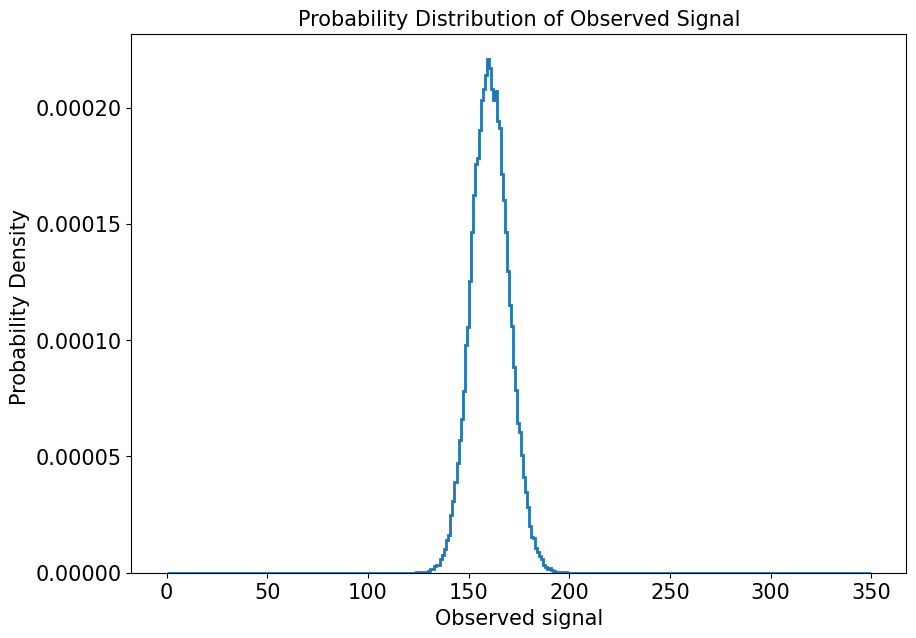

In [86]:
# check by plotting
plt.stairs(Psd[:, signal], edges = dataedges, linewidth = 2)
plt.title(f'Probability Distribution of Observed Signal', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability Density ', fontsize = 15)
plt.xlabel('Observed signal', fontsize = 15)
plt.show()

As we observe, a true signal of 75 events would produce a 95% probability of seeing an observed value of 145 or greater. This means that if the true Higgs boson signal were stronger than 75 events I would observe a Higgs boson event 95% of the time.

Next let's calculate the observed 95% confidence level upper limit, which is based on the observed number of low luminosity events which we found to be 24 events in part 2.

In [87]:
desired_prob = 0.95
prob = 0
signal = 0

for i in range (0,350):
    # draw horizontal slice at true signal = 0 and normalize
    prob_signal = Psd[:,signal]
    prob_signal = prob_signal*(1/(np.sum(prob_signal)))

    # integrate from observed value (24) of higgs signal and background to infinity
    for j in range (24, len(prob_signal)):
        prob += prob_signal[j]
        
    if prob >= desired_prob:
        break
    
    prob = 0
            
    signal += 1
    
print(f'The observed {desired_prob*100}% confidence level upper limit is {signal} events.')

The observed 95.0% confidence level upper limit is 0 events.


Let's check if this makes sense by plotting the probability distribution of observed signals given a true signal of 0 events.

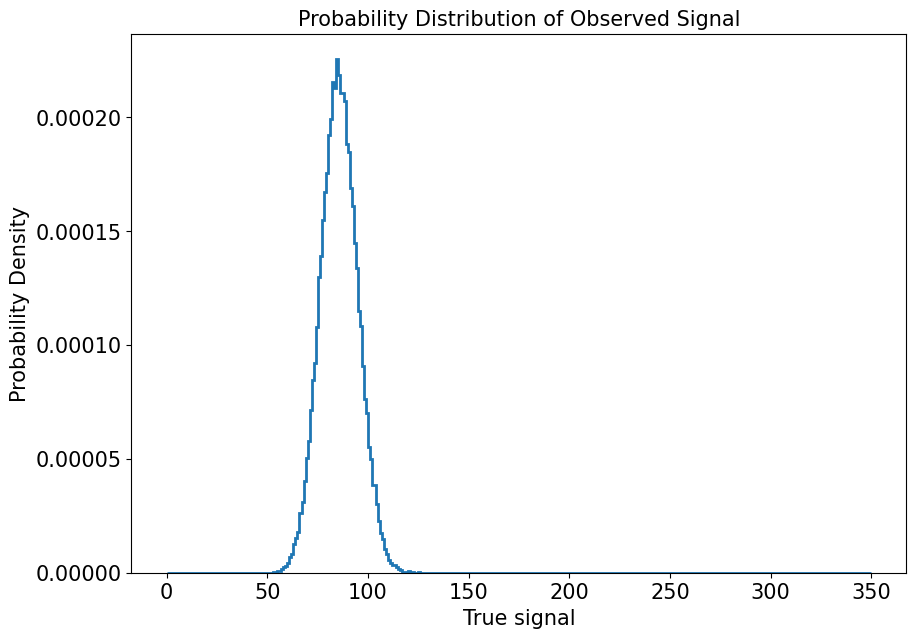

In [90]:
# check by plotting
plt.stairs(Psd[:, signal], edges = dataedges, linewidth = 2)
plt.title(f'Probability Distribution of Observed Signal', fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Probability Density', fontsize = 15)
plt.xlabel('True signal', fontsize = 15)
plt.show()

The probability distribution above makes sense because if a true signal were 0, the mean value would be the expected yield of the qcd background (85 events). An observation of 24 would encapsulate more than 95% of the probability in the area to the right, under the curve. Therefore the observed 95% confidence level upper limit is 0 events. Since the background has a lambda parameter of 85, the observation of 24 is below this value and this means the signal would need to be negative to get an observation of 24. This explains why our observed significance for the low luminosity data is negative. The low luminosity dataset seems to have too few data measurements to provide much information for us about the higgs boson under our event selection.

The expected 95% confidence level upper limit is 75 events, while the observed 95% confidence level upper limit is 0 events. This is because for any true signal greater than 0, I would have a measurement corresponding to a significant observation of the Higgs signal more than 95% of the time from the low luminosity data. Thus I can say with confidence that the low luminosity data has no Higgs signal, which is consistent with my data plots from part 2.